## Download Data

In [1]:
# !wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
# !tar xvzf lfw.tgz 

In [1]:
from pathlib import Path
def ls(self):
    return list(self.iterdir())
Path.ls = ls

import itertools
from random import shuffle


import os
import time
import matplotlib.pyplot as plt
import numpy as np
from fastprogress import progress_bar
from copy import deepcopy
from fastai.vision import *

In [2]:
folders = Path('lfw')
all = set()
no_dups = set()
dups = set()
for folder in folders.ls():
    name = folder.name
    if len(folder.ls()) == 1:
        no_dups.add(name)
    else: dups.add(name)
    all.add(name)

In [4]:
class ItemTuple(ItemBase):
    
    def __init__(self, items):
        # Warn if the items gets larger than intended
        self.size = len(items) 
        self.items = items
        self.data = torch.cat([x.data.unsqueeze(0) for x in items])
    
    def show(self):
        [x.show() for x in self.items]
        
    def apply_tfms(self, tfms, **kwargs):
        self.items = [item.apply_tfms(tfms,**kwargs) for item in self.items]
        self.data = torch.cat([x.data.unsqueeze(0) for x in self.items])
        return self
    
    def __repr__(self):
        return ''.join([str(x) for x in self.items]) + '\n'
    
    def __len__(self):
        return self.size

In [5]:
class SiameseList(ItemList):
    
    def __init__(self, *args, open_fn=lambda x:x, **kwargs):
        super().__init__(*args, **kwargs)
        self.open = open_fn
        
    def get(self, i):
        item = super().get(i)
        if isinstance(item, ItemTuple):
            return item
        return ItemTuple([self.open(x) for x in item])

In [22]:
from copy import deepcopy

class SiameseDataset(LabelList):
    
    def show_similar(self):
        pass
        
    def show_different(self):
        pass
    
    @classmethod
    def from_label_list(cls, ll:LabelList, hidden_classes=None, train_num=20, valid_num=10, use_all=False, vll_=None):
        # Use random chunk of the classes for validation if none specified
        if hidden_classes is None: hidden_classes = list(range(ll.c))[-int(ll.c*0.2)]
        
        if hasattr(hidden_classes[0], 'data'):
            hidden_classes = [x.data for x in hidden_classes]

        if len(hidden_classes) < 2:
            raise Exception("Must be atleast 2 classes")
        
        train_cls = [i for i in range(ll.c - 1) if i not in hidden_classes]
        
        def mask(i,c): 
            return i.y.items == c

        # Copy to get transforms
        tll = deepcopy(ll)
        # Generate Items and Labels
        tll.x.items = np.concatenate([ll.x.items[mask(ll,c)] for c in train_cls])
        tll.y.items = np.concatenate([ll.y.items[mask(ll,c)] for c in train_cls])
        tll = cls._from_label_list(tll, train_num, train_num//2, use_all)

        if vll_:
            vll = vll_

        else:
            vll = deepcopy(ll)        
            vll.x.items = np.concatenate([ll.x.items[mask(ll,c)] for c in hidden_classes])
            vll.y.items = np.concatenate([ll.y.items[mask(ll,c)] for c in hidden_classes])       
            vll = cls._from_label_list(vll, valid_num, valid_num//2, use_all)     
            
        return LabelLists(ll.x.path, tll, vll)
    
    @classmethod    
    def _from_label_list(cls, ll:LabelList, num_same=20, num_diff=30, use_all=False, sample_hard=False):
        x = ll.x
        y = ll.y
        class2paths = {}      
        for x_, y_ in zip(x.items,y.items):
            if y_ not in class2paths.keys():
                class2paths[y_] = [x_]
            else:
                class2paths[y_].append(x_)
        # Seperate into lists of individual classes
        # Some of these may be empty because of the spit
        seperated = [x.items[y.items==c] for c in range(ll.c) if len(x.items[y.items==c]) > 0]
        count = Counter(ll.y.items)
              
        #possible sames
        same_idxs = [k for k,v in count.items() if v>1]
        sampled_same = np.random.choice(same_idxs, num_same)           
        same_pairs = np.empty((0,2))
        for same in sampled_same:
            r = np.random.choice(class2paths[same],size=2,replace=False)[None]
            same_pairs = np.concatenate([same_pairs, r])
        
        # Create pairs of different items
        all_idx = list(count.keys())
        sampled_diff = np.random.choice(all_idx,size=num_diff*2,replace=True)
        diff_pairs = np.empty((0,2))
       
        for name1,name2 in zip(sampled_diff[:num_diff], sampled_diff[num_diff:]):
            r1 = np.random.choice(class2paths[name1],size=1,replace=False)[None]
            r2 = np.random.choice(class2paths[name2],size=1,replace=False)[None]
            diff_pairs = np.concatenate([diff_pairs, np.hstack([r1,r2])])
        
        # Combine together 
        al = np.concatenate([same_pairs, diff_pairs])
        # Generate labels
        labels = np.concatenate([np.ones(len(same_pairs), dtype=np.int8), np.zeros(len(diff_pairs), dtype=np.int8)])
        
        inst = cls(SiameseList(al, open_fn=ll.x.open), CategoryList(labels, ['different', 'similar']))
        return inst

In [7]:
imgs = ImageList.from_folder('lfw').split_none().label_from_func(lambda x: x.parent.name)

In [8]:
count = Counter(imgs.train.y.items)
np.random.seed(42)
val_idx = [k for k,v in count.items() if v>4 and np.random.random() < 0.8]

In [9]:
val_classes = np.array(imgs.classes)[val_idx]

In [10]:
sd = SiameseDataset.from_label_list(imgs.train, val_idx, 3000, 1000)
data = sd.transform(get_transforms(), size=224).databunch(bs=30)

In [11]:
class SiameseNetwork(nn.Module):
    
    def __init__(self, encoder=models.resnet18, s_out=512):
        # TODO warn is s_out is to large
        super().__init__()
        self.body = create_body(encoder, cut=-2)
        self.head = create_head(1024, 1, [s_out])[:5]
        
        #normalize images
        self.mean = tensor(imagenet_stats[0])[None,None,:,None,None].cuda()
        self.std = tensor(imagenet_stats[1])[None,None,:,None,None].cuda()
        
        self.pred = nn.Linear(s_out,1)
        
    def forward(self, items):
        bs = len(items)
        # Get the batch size in the correct place
        items = (items - self.mean)/self.std
        ins = items.transpose(1, 0)
        outs = [self.body(x)  for x in ins]
        outs = [self.head(x) for x in outs]
        outs = torch.stack(outs)
        dist = torch.pow(outs[0]-outs[1], 2)
        preds = self.pred(dist)
        return dist, preds

# Loss Function

In [12]:
MARGIN = 4

In [13]:
def hinge_loss(x, y, m=MARGIN):
    diff = x
    diff = diff.mean(-1)
    diff[y==0] = m**2 - diff[y==0]
    diff[diff < 0] = 0
    return diff

def loss(x,y):
    dist, preds = x
    l = hinge_loss(dist,y).mean()
    l2 = nn.BCEWithLogitsLoss()(preds.squeeze(),y.float())
    return l + 10*l2

def hinge_acc(x,y,l=MARGIN/2):
    return (hinge_loss(x[0],y) < l**2).float().mean()

def ce_acc(x,y):
    return accuracy_thresh(x[1],y)

In [14]:
def siamese_learner(data: DataBunch, encoder:nn.Module=models.resnet18, s_out=512, loss_func=None, loss_size=None, m=3):
    learner = Learner(data, SiameseNetwork(encoder, s_out), loss_func=loss, metrics=[hinge_acc,ce_acc])
    learner.encode = lambda x: x # TODO create a simple way to get a vector of a piece of data
    return learner    

# Here we decide the length of the output vector. 
# This will be dependent on your encoder arch (bigger means bigger s_out)
learn = siamese_learner(data, encoder=models.resnet18, s_out=256)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


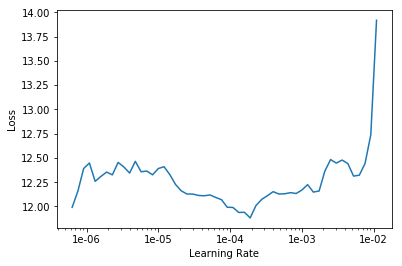

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(30, 1e-4)

epoch,train_loss,valid_loss,hinge_acc,ce_acc,time
0,12.103128,12.130288,0.666667,0.641556,00:41
1,12.030656,11.990338,0.666667,0.668889,00:41
2,11.907465,11.706171,0.666667,0.720445,00:41
3,10.974286,10.907564,0.666667,0.767111,00:41
4,10.127534,10.284786,0.666667,0.800000,00:41
5,8.815431,10.008642,0.666667,0.813333,00:42
6,7.953764,9.520483,0.680000,0.805111,00:42
7,6.501024,8.762704,0.744667,0.791111,00:41
8,5.475644,8.285550,0.740667,0.820445,00:42
9,4.889827,8.301057,0.740000,0.820667,00:42


Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/lib/python3.7/

KeyboardInterrupt: 

We randomly sample a new training set but retain the old validation set.

In [23]:
sd = SiameseDataset.from_label_list(imgs.train, val_idx, 3000, 1000, vll_=learn.data.valid_ds)
data = sd.transform(get_transforms(), size=224).databunch(bs=30)

In [24]:
learn.data = data
learn.fit_one_cycle(7, 1e-4)

epoch,train_loss,valid_loss,hinge_acc,ce_acc,time
0,6.802286,7.946409,0.758000,0.822000,00:41
1,6.202328,7.411335,0.772667,0.840222,00:41
2,5.684734,7.578803,0.766000,0.839778,00:42
3,4.566235,7.304679,0.771333,0.843333,00:42
4,3.857183,7.432458,0.782000,0.855111,00:42
5,3.476911,7.601839,0.775333,0.854222,00:42
6,3.050252,7.629997,0.777333,0.858222,00:42


In [25]:
learn.save('2_v2')

In [26]:
sd = SiameseDataset.from_label_list(imgs.train, val_idx, 5000, 1000, vll_=learn.data.valid_ds)
data = sd.transform(get_transforms(), size=224).databunch(bs=30)
learn.data = data
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,hinge_acc,ce_acc,time
0,5.747616,7.016694,0.777333,0.856000,01:05
1,5.687004,6.966292,0.776667,0.859333,01:05
2,5.359519,6.983399,0.789333,0.865333,01:05
3,4.791476,7.685415,0.774667,0.857778,01:05
4,4.038931,7.348262,0.789333,0.850889,01:05
5,3.535996,6.857975,0.786667,0.868889,01:05
6,3.074110,7.105122,0.790667,0.869333,01:06
7,2.729534,7.243258,0.789333,0.872667,01:05
8,2.422235,7.259499,0.789333,0.877111,01:05
9,2.285249,7.207003,0.791333,0.874444,01:05


In [27]:
learn.save('3_v2')

In [28]:
sd = SiameseDataset.from_label_list(imgs.train, val_idx, 5000, 1000, vll_=learn.data.valid_ds)
data = sd.transform(get_transforms(), size=224).databunch(bs=30)
learn.data = data
learn.fit_one_cycle(8, 1e-4)

epoch,train_loss,valid_loss,hinge_acc,ce_acc,time
0,4.947531,6.811254,0.796667,0.856889,01:04
1,4.927116,6.896203,0.793333,0.855555,01:05
2,4.656823,6.538965,0.803333,0.857778,01:04
3,3.808827,6.062382,0.806000,0.879556,01:05
4,3.357447,6.078907,0.813333,0.884000,01:05
5,2.691316,6.108104,0.816667,0.887333,01:05
6,2.309016,6.158706,0.816667,0.885333,01:05
7,2.346493,6.193950,0.817333,0.889333,01:05


In [29]:
learn.save('4_v2')

In [31]:
learn.load('4_v2');
learn.fit_one_cycle(10, 1e-5)

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type SiameseNetwork. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch,train_loss,valid_loss,hinge_acc,ce_acc,time
0,2.092045,6.192647,0.814000,0.889333,01:05
1,2.225828,6.047504,0.816667,0.891333,01:06
2,2.082879,6.205244,0.820000,0.890667,01:06
3,1.999258,6.232928,0.816000,0.888000,01:06
4,1.942400,6.265812,0.820667,0.895333,01:06
5,1.866558,6.262212,0.818000,0.890000,01:05
6,1.932559,6.330747,0.817333,0.890000,01:05
7,1.821096,6.316938,0.812667,0.888000,01:05
8,1.825383,6.313887,0.816000,0.887333,01:06
9,1.856655,6.303589,0.816667,0.890667,01:05


In [32]:
learn.save('5_v2')

# Inference

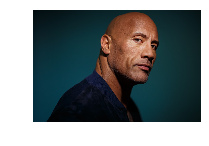

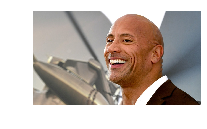

In [37]:
hobbs1 = open_image('images/hobbs1.jpeg')
hobbs1.show()

hobbs2 = open_image('images/hobbs2.jpg')
hobbs2.show()

Model is pretty confident that these two are the same guys.

In [66]:
inp = torch.stack([hobbs1.resize(224).px[None],hobbs2.resize(224).px[None]],1)
_,p = learn.model(inp.cuda())
p.sigmoid()

tensor([[0.9903]], device='cuda:0', grad_fn=<SigmoidBackward>)

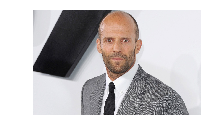

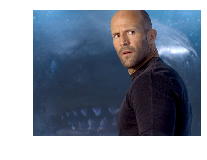

In [67]:
shaw1 = open_image('images/shaw1.jpg')
shaw1.show()

shaw2 = open_image('images/shaw2.jpg')
shaw2.show()

A little less confident here, but we'll take it.

In [68]:
inp = torch.stack([shaw1.resize(224).px[None],shaw2.resize(224).px[None]],1)
_,p = learn.model(inp.cuda())
p.sigmoid()

tensor([[0.7831]], device='cuda:0', grad_fn=<SigmoidBackward>)

What does the model think about different people? Well fuck, the model thinks all bald guys are the same.

In [71]:
inp = torch.stack([shaw1.resize(224).px[None],hobbs1.resize(224).px[None]],1)
_,p = learn.model(inp.cuda())
p.sigmoid()

tensor([[0.9487]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [72]:
inp = torch.stack([shaw2.resize(224).px[None],hobbs1.resize(224).px[None]],1)
_,p = learn.model(inp.cuda())
p.sigmoid()

tensor([[0.9520]], device='cuda:0', grad_fn=<SigmoidBackward>)

Well, at least the model can tell apart males and females.:) 

tensor([[4.5366e-05]], device='cuda:0', grad_fn=<SigmoidBackward>)

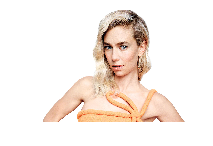

In [73]:
kirby1 = open_image('images/kirby1.jpg')
kirby1.show()

inp = torch.stack([shaw2.resize(224).px[None],kirby1.resize(224).px[None]],1)
_,p = learn.model(inp.cuda())
p.sigmoid()

In [74]:
inp = torch.stack([hobbs2.resize(224).px[None],kirby1.resize(224).px[None]],1)
_,p = learn.model(inp.cuda())
p.sigmoid()

tensor([[3.9535e-06]], device='cuda:0', grad_fn=<SigmoidBackward>)

# Curriculum Learning - DOESNT WORK

We sample hard cases, and work on those. We are primarily looking for different pairs with distances that are too close.

In [283]:
names = imgs.train.y.classes
all_ims_data = imgs.transform(size=224).databunch(bs=40)
paths_of_name = {folder.name:folder.ls() for folder in folders.ls() if folder.name in names}

We expect to see higher training losses than before, this is because we deliberately sampled pairs that are more difficult.

In [284]:
def get_training_data():
    K=2
    features = []
    print('Calculating features for all images.')
    for xb,yb in all_ims_data.fix_dl:
        features.append(learn.model.head(learn.model.body(xb)).detach()) 
    features = torch.cat(features).cuda()    
    print('Calculating similarity between images.')
    dists = {}
    for i, im in enumerate(progress_bar(all_ims_data.fix_dl.items[:len(features)])):
        dists[im] = torch.pairwise_distance(features[i], features).cpu().numpy()
    all_train_ims = all_ims_data.fix_dl.items

    #filter out images that belong to validation classes
    relevant_idx = [n for n,im in enumerate(all_train_ims[:len(features)]) if im.parent.name not in val_classes]
    all_train_ims = all_train_ims[relevant_idx]
    features = features[relevant_idx]      

    print(f'Sampling different pairs for all training images.')
    diff_pairs = np.empty((0,2))
    for curr_im in progress_bar(all_train_ims):
        curr_person = paths_of_name[curr_im.parent.name]
        diff_files = []
        dist = []
        name_dist = [(fname,d) for fname,d in zip(all_train_ims[:len(features)],dists[curr_im]) if fname not in curr_person]
        name_dist.sort(key = lambda x:x[1])
        for p,d in name_dist[:K]:
            to_append = np.array([curr_im,p])[None]
            diff_pairs = np.concatenate([diff_pairs,to_append])                        

    print(f'Sampling same pairs for all training images.')
    same_pairs = np.empty((0,2))
    for k,v in progress_bar(paths_of_name.items()):
        if k in val_classes: continue
        if len(v) <= 1: continue

        #all combinations of two
        all_combs = np.array(list(itertools.combinations(v,2)))
        same_pairs = np.concatenate([same_pairs,all_combs])           


    # Combine together 
    al = np.concatenate([same_pairs, diff_pairs])
    # Generate labels
    labels = np.concatenate([np.ones(len(same_pairs), dtype=np.int8), np.zeros(len(diff_pairs), dtype=np.int8)])

    tll = SiameseDataset(SiameseList(al, open_fn=imgs.train.x.open), CategoryList(labels, ['different', 'similar']))
    return tll

In [285]:
tll = get_training_data()
src = LabelLists(imgs.train.x.path, tll, data.valid_ds)

Calculating features for all images.
Calculating similarity between images.


Sampling different pairs for all training images.


Sampling same pairs for all training images.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


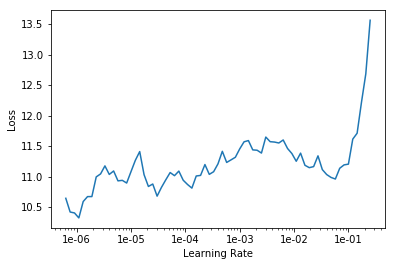

In [286]:
data = src.transform(get_transforms(), size=224).databunch(bs=30)
learn.data = data
learn = learn.clip_grad(1)
learn.lr_find()
learn.recorder.plot()

In [291]:
learn.fit_one_cycle(1,5e-5)

epoch,train_loss,valid_loss,hinge_acc,ce_acc,time
0,8.011114,10.337516,0.744000,0.741111,04:38


In [292]:
tll = get_training_data()
src = LabelLists(imgs.train.x.path, tll, data.valid_ds)
data = src.transform(get_transforms(), size=224).databunch(bs=30)
learn.data = data
learn.fit_one_cycle(1,5e-5)

Calculating features for all images.
Calculating similarity between images.


Sampling different pairs for all training images.


Sampling same pairs for all training images.


epoch,train_loss,valid_loss,hinge_acc,ce_acc,time
0,6.754654,10.503052,0.724000,0.734667,04:37
